# Automobile Sales Assignment — Full (Part 1 & Part 2)
Parth Suri

This notebook runs Tasks 1 and 2 for the assignment. It reads `automobile_sales_20000.csv` (already present) and creates all required plots and a Dash app file. Run the cells in order.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
sns.set_style('whitegrid')

DATA_CSV = 'automobile_sales_20000.csv'
df = pd.read_csv(DATA_CSV, parse_dates=['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
print('Loaded', len(df), 'rows from', DATA_CSV)


Loaded 20000 rows from automobile_sales_20000.csv


## Part 1 — Visualization Tasks
### Task 1.1: Line Plot of Total Sales per Year (saves `Line_plot_1.png`)

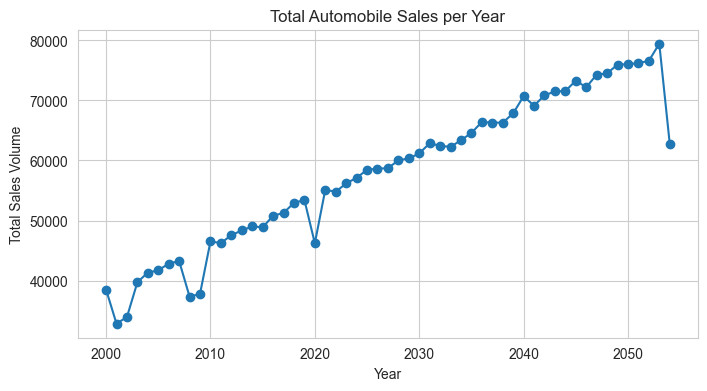

In [28]:
annual = df.groupby('year')['sales_volume'].sum().reset_index()
plt.figure(figsize=(8,4))
plt.plot(annual['year'], annual['sales_volume'], marker='o')
plt.title('Total Automobile Sales per Year')
plt.xlabel('Year')
plt.ylabel('Total Sales Volume')
plt.savefig('Line_plot_1.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.2: Annual Sales by Vehicle Type (saves `Line_plot_2.png`)

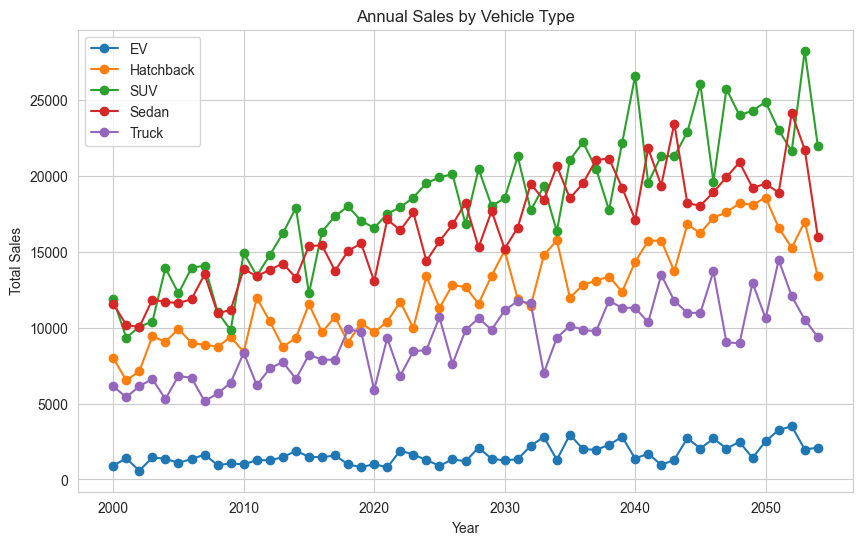

In [29]:
annual_type = df.groupby(['year','vehicle_type'])['sales_volume'].sum().reset_index()
plt.figure(figsize=(10,6))
for t in annual_type['vehicle_type'].unique():
    subset = annual_type[annual_type['vehicle_type']==t]
    plt.plot(subset['year'], subset['sales_volume'], marker='o', label=t)
plt.title('Annual Sales by Vehicle Type')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend()
plt.savefig('Line_plot_2.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.3: Seaborn comparison (recession vs non-recession) — saves `Bar_Chart.png`

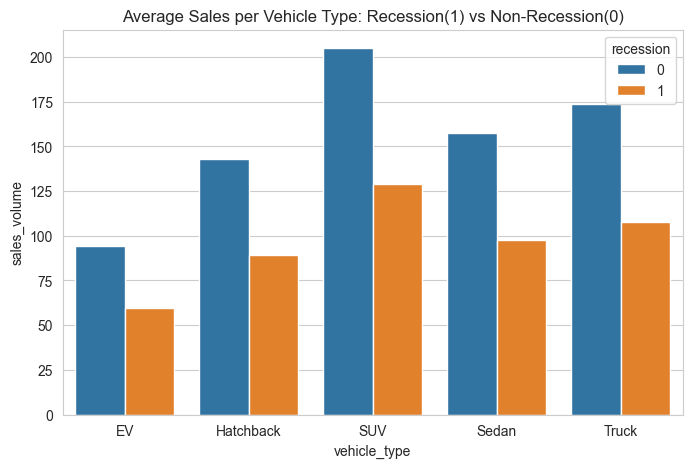

In [30]:
rec_agg = df.groupby(['recession','vehicle_type'])['sales_volume'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=rec_agg, x='vehicle_type', y='sales_volume', hue='recession')
plt.title('Average Sales per Vehicle Type: Recession(1) vs Non-Recession(0)')
plt.savefig('Bar_Chart.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.4: GDP subplots for recession vs non-recession (saves `Subplot.png`)

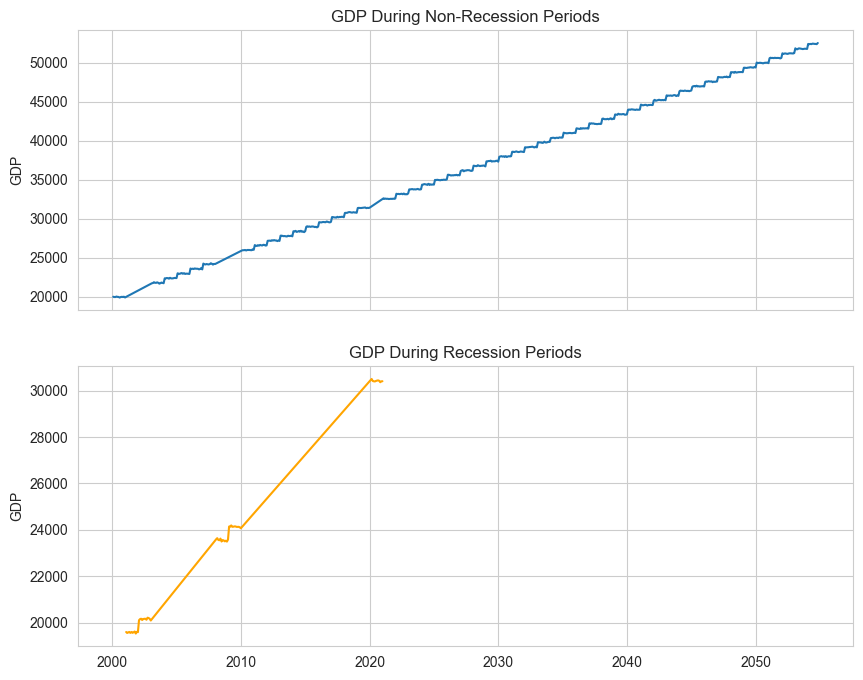

In [31]:
df_month = df.set_index('date').groupby([pd.Grouper(freq='ME'),'recession'])['gdp'].mean().reset_index()
fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
rec0 = df_month[df_month['recession']==0]
rec1 = df_month[df_month['recession']==1]
axes[0].plot(rec0['date'], rec0['gdp'], label='Non-Recession')
axes[0].set_title('GDP During Non-Recession Periods')
axes[1].plot(rec1['date'], rec1['gdp'], color='orange', label='Recession')
axes[1].set_title('GDP During Recession Periods')
for ax in axes:
    ax.set_ylabel('GDP')
plt.savefig('Subplot.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.5: Bubble plot for seasonality (saves `Bubble.png`)

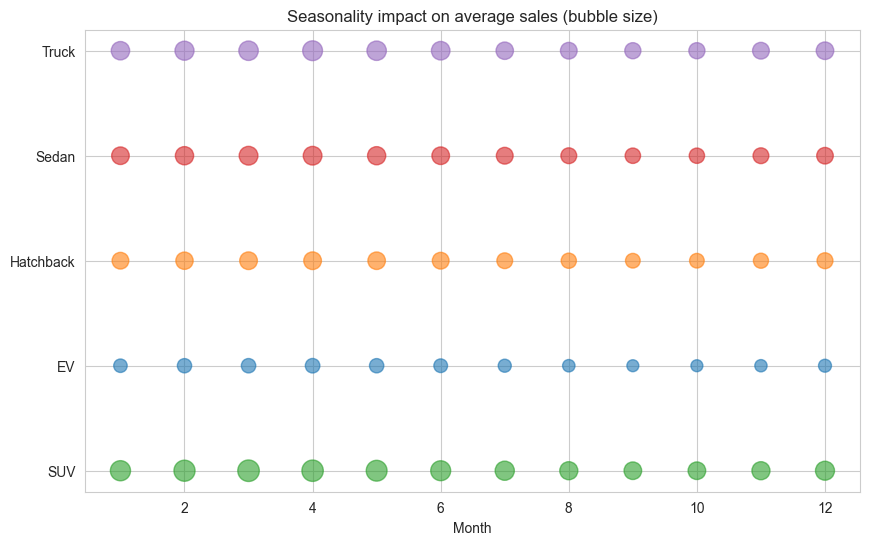

In [32]:
bubble = df.groupby(['month','vehicle_type'])['sales_volume'].mean().reset_index()
plt.figure(figsize=(10,6))
# map vehicle types to numeric y positions for plotting
vtypes = list(df['vehicle_type'].unique())
ypos = {v:i for i,v in enumerate(vtypes)}
for vt in bubble['vehicle_type'].unique():
    sub = bubble[bubble['vehicle_type']==vt]
    plt.scatter(sub['month'], [ypos[vt]]*len(sub), s=(sub['sales_volume']), alpha=0.6, label=vt)
plt.yticks(list(ypos.values()), list(ypos.keys()))
plt.xlabel('Month')
plt.title('Seasonality impact on average sales (bubble size)')
plt.savefig('Bubble.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.6: Scatter plot price vs sales in recessions (saves `Scatter.png`)

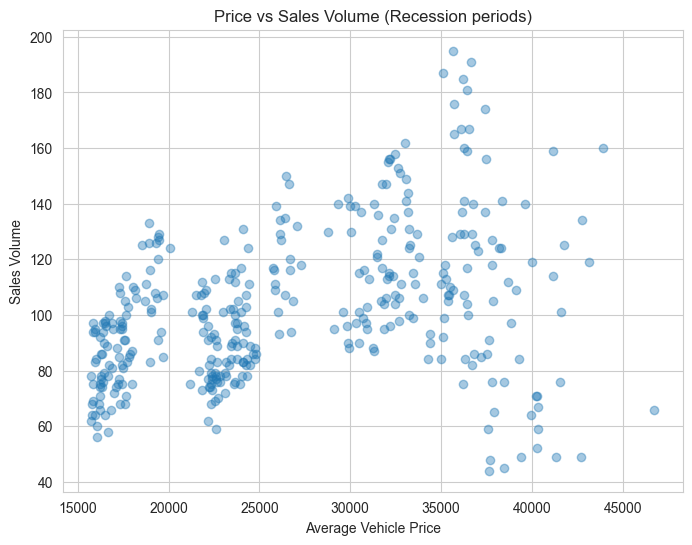

In [33]:
rec_df = df[df['recession']==1].sample(frac=0.2, random_state=1)
plt.figure(figsize=(8,6))
plt.scatter(rec_df['avg_price'], rec_df['sales_volume'], alpha=0.4)
plt.xlabel('Average Vehicle Price')
plt.ylabel('Sales Volume')
plt.title('Price vs Sales Volume (Recession periods)')
plt.savefig('Scatter.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.7: Pie chart ad expenditure: recession vs non-recession (saves `Pie_1.png`)

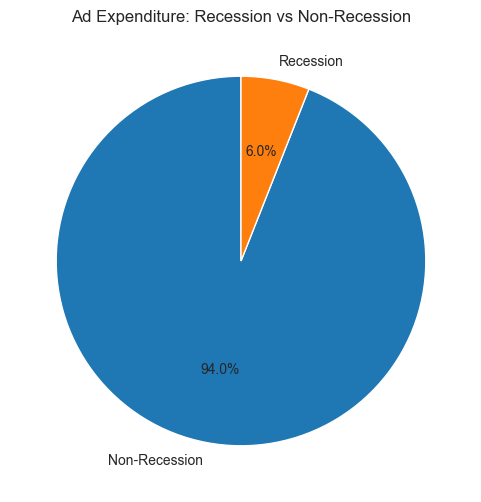

In [34]:
pie1 = df.groupby('recession')['ad_expenditure_k'].sum()
plt.figure(figsize=(6,6))
plt.pie(pie1, labels=['Non-Recession','Recession'], autopct='%1.1f%%', startangle=90)
plt.title('Ad Expenditure: Recession vs Non-Recession')
plt.savefig('Pie_1.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.8: Pie chart ad expenditure by vehicle type during recession (saves `Pie_2.png`)

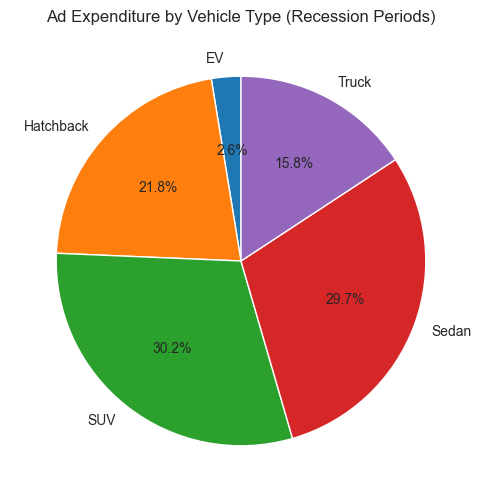

In [35]:
pie2 = df[df['recession']==1].groupby('vehicle_type')['ad_expenditure_k'].sum()
plt.figure(figsize=(6,6))
plt.pie(pie2, labels=pie2.index, autopct='%1.1f%%', startangle=90)
plt.title('Ad Expenditure by Vehicle Type (Recession Periods)')
plt.savefig('Pie_2.png', bbox_inches='tight', dpi=150)
plt.show()


### Task 1.9: Line plot - unemployment by year & vehicle type during recession (saves `Line_plot_3.png`)

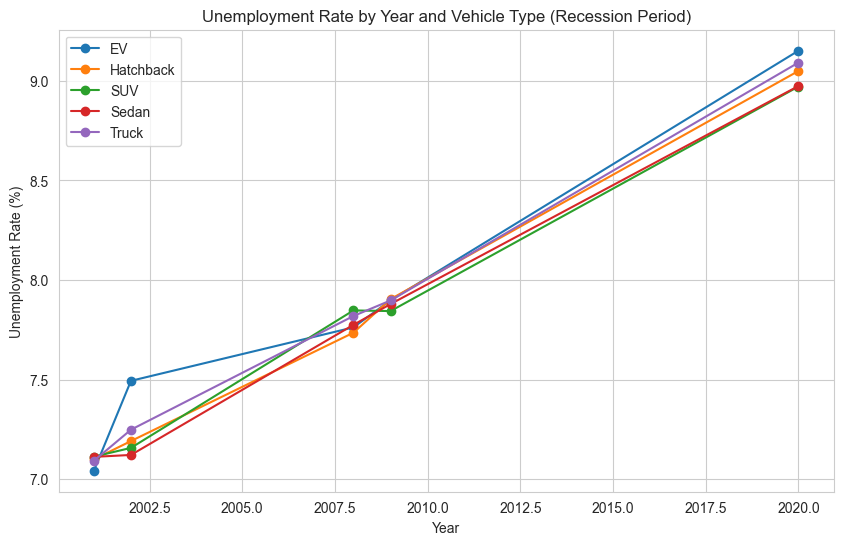

In [36]:
yr = df[df['recession']==1].groupby(['year','vehicle_type']).agg({'sales_volume':'mean','unemployment':'mean'}).reset_index()
plt.figure(figsize=(10,6))
for vt in yr['vehicle_type'].unique():
    sub = yr[yr['vehicle_type']==vt]
    plt.plot(sub['year'], sub['unemployment'], marker='o', label=vt)
plt.title('Unemployment Rate by Year and Vehicle Type (Recession Period)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.savefig('Line_plot_3.png', bbox_inches='tight', dpi=150)
plt.show()


## Part 2 — Dashboard (Dash)
This section writes a Dash app `dash_app.py`, and generates simple screenshot images used for submission: Title, Dropdown, output div, Callbacks, RecessionReportgraphs, YearlyReportgraphs.

In [ ]:
dash_code = '''# dash_app.py - simple Dash app for the assignment
import dash
from dash import html, dcc, Output, Input
import plotly.express as px
import pandas as pd

df = pd.read_csv('automobile_sales_20000.csv', parse_dates=['date'])
app = dash.Dash(__name__)
app.title = 'Automobile Sales Recession Dashboard'

app.layout = html.Div([
    html.H1('Automobile Sales Recession Dashboard', id='title'),
    html.Div([
        dcc.Dropdown(id='vehicle-dropdown', options=[{'label':t,'value':t} for t in df['vehicle_type'].unique()], value='Sedan'),
        dcc.Dropdown(id='stat-dropdown', options=[{'label':'Sales Volume','value':'sales_volume'},{'label':'Avg Price','value':'avg_price'}], value='sales_volume')
    ], style={'width':'40%'}),
    html.Div(id='output-div', className='output-container'),
    dcc.Graph(id='main-graph')
])

@app.callback([Output('output-div','children'), Output('main-graph','figure')],
              [Input('vehicle-dropdown','value'), Input('stat-dropdown','value')])
def update(vehicle, stat):
    dff = df[df['vehicle_type']==vehicle]
    fig = px.line(dff, x='date', y=stat, title=f'{vehicle} - {stat} over time')
    summary = f"Selected: {vehicle} | Stat: {stat} | Rows: {len(dff)}"
    return summary, fig

if __name__ == '__main__':
    app.run(debug=True)
'''
with open('dash_app.py','w') as f:
    f.write(dash_code)
print('dash_app.py written')

dash_app.py written


In [38]:
# create simple text images to use as submission screenshots
def text_image(text, filename, figsize=(8,2)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.text(0.5,0.5, text, ha='center', va='center', fontsize=14)
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()

text_image('Automobile Sales Recession Dashboard', 'Title.png')
text_image('Dropdowns: [Vehicle Type], [Statistics]', 'Dropdown.png')
text_image("Output division: id='output-div' class='output-container'", 'outputdiv.png')
text_image('Callbacks: update output-div and main-graph based on dropdowns', 'Callbacks.png')

# Recession report graphs (3 small bar plots in one row)
rec_agg2 = df[df['recession']==1].groupby('vehicle_type').agg({'sales_volume':'sum','ad_expenditure_k':'sum','unemployment':'mean'})
fig, axes = plt.subplots(1,3, figsize=(15,4))
rec_agg2['sales_volume'].plot(kind='bar', ax=axes[0], title='Sales (sum) during recession')
rec_agg2['ad_expenditure_k'].plot(kind='bar', ax=axes[1], title='Ad Expenditure (sum) during recession')
rec_agg2['unemployment'].plot(kind='bar', ax=axes[2], title='Avg Unemployment during recession')
plt.tight_layout()
plt.savefig('RecessionReportgraphs.png', dpi=150)
plt.close()

# Yearly report graphs (2 plots)
yr_sales = df.groupby('year')['sales_volume'].sum()
yr_price = df.groupby('year')['avg_price'].mean()
fig, axes = plt.subplots(1,2, figsize=(14,4))
yr_sales.plot(ax=axes[0], title='Total Sales per Year')
yr_price.plot(ax=axes[1], title='Average Price per Year')
plt.tight_layout()
plt.savefig('YearlyReportgraphs.png', dpi=150)
plt.close()

print('All Part2 images saved (Title.png, Dropdown.png, outputdiv.png, Callbacks.png, RecessionReportgraphs.png, YearlyReportgraphs.png)')

All Part2 images saved (Title.png, Dropdown.png, outputdiv.png, Callbacks.png, RecessionReportgraphs.png, YearlyReportgraphs.png)


In [39]:
import os
print('Files in working dir:')
for f in sorted(os.listdir('.')):
    if f.endswith('.png') or f.endswith('.csv') or f.endswith('.py') or f.endswith('.ipynb'):
        print(' -', f)


Files in working dir:
 - 2025_C1_C2_C3_C4_pcms (1).csv
 - 2025_C1_C2_C3_C4_pcms.csv
 - 300_happy_and_sad_songs.csv
 - 3d-rendering-house-model (1) 1.png
 - 3d-rendering-house-model (3) 1.png
 - 3d-rendering-isometric-fdgdf 1(1).png
 - 3d-rendering-isometric-fdgdf 1.png
 - 7_annotation.csv
 - 7_data (1).csv
 - 7_data.csv
 - ARVA-removebg-preview 2.png
 - Aarvasa Logo svg 1.png
 - Aarvasa_Logo-removebg 2.png
 - Aarvasa_Logo-removebg 3(1).png
 - Aarvasa_Logo-removebg 3(2).png
 - Aarvasa_Logo-removebg 3(3).png
 - Aarvasa_Logo-removebg 3.png
 - ActionItemList.csv
 - American Express.csv
 - AwsServices.csv
 - BCGTASK3.ipynb
 - BCGTASK4.ipynb
 - BCGTASK5.ipynb
 - Bar_Chart.png
 - Bubble.png
 - Callbacks.png
 - ChatGPT Image Apr 3, 2025, 09_10_48 PM.png
 - ChatGPT Image Apr 3, 2025, 09_35_39 PM.png
 - ChatGPT Image Apr 4, 2025, 12_02_27 AM.png
 - ChatGPT Image Apr 4, 2025, 12_04_28 AM.png
 - ChatGPT Image Apr 4, 2025, 12_04_29 AM.png
 - ChatGPT Image Apr 4, 2025, 12_09_33 AM.png
 - ChatGPT Ima